# Dia 1: Basics
* Problematica
    * Nos comentan que existe una crisis de rotacion de personal
    * Reducir la fuga de empleados
    * Perdida de empleado, talento y costos de reemplazo
* Objetivos
    * Entender y cuantificar el problema desde el punto de vista de negocio
    * Desarrollar un sistema automatizado de machine learning que identifique a los empleados que están en mayor riesgo de fuga
    * Comunicar los resultados de forma exitosa a la dirección
* Estructura del proyecto
    * Business Analytics
    * Machine learning
    * Productivizacion

---------------------------------------------

## Tareas de dia 1
- [x] Descargar archivo csv
- [x] Crear entorno
- [x] Cargar los datos

## Librerias

In [392]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
import plotly.express as px

## Carga de datos

In [393]:
df = pd.read_csv('AbandonoEmpleados.csv', sep = ';', index_col= 'id', na_values='#N/D')
df.sample(3)

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,empleados,satisfaccion_entorno,sexo,...,satisfaccion_companeros,horas_quincena,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,conciliacion,anos_compania,anos_en_puesto,anos_desde_ult_promocion,anos_con_manager_actual
id,,,,,,,,,,,,,,,,,,,,,
1329,41,No,Non-Travel,Sales,10,Primaria,Medical,1,Alta,NaN,...,Baja,80,0,19,4,Baja,19,NaN,11,9
1373,56,No,Travel_Rarely,Research & Development,23,Universitaria,Life Sciences,1,Muy_Alta,3.0,...,Baja,80,1,33,0,NaN,19,NaN,15,9
1100,35,Yes,Travel_Rarely,Sales,4,Universitaria,Technical Degree,1,Muy_Alta,3.0,...,Baja,80,0,9,2,NaN,8,NaN,4,7


# Dia 2:  Business Analytics

## Limpieza de datos

In [394]:
# Revisamos que datos tenemos y el tipo de cada uno
print('La forma de nuestro database ', 
      df.shape[1], 'columnas y ',
      df.shape[0], ' filas')
df.info()

La forma de nuestro database  31 columnas y  1470  filas
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   object 
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1369 non-null   object 
 6   carrera                   1470 non-null   object 
 7   empleados                 1470 non-null   int64  
 8   satisfaccion_entorno      1470 non-null   object 
 9   sexo                      1271 non-null   float64
 10  implicacion               1452 non-null   object 
 11  nivel_laboral             1470 non-null   int64  
 12  puesto                    1470 non-null   object 
 13  satisfaccio

### Variables con valores unicos
* Podemos eliminar estas variables ya que no aportan informacion por tener un solo valor
* Analizando si hay variables con valores unicos de los que podemos prescindir

In [395]:
# lista de variables que tienen un valor unico
for i in df.columns:
    unicos = len(df[i].unique())
    if unicos==1:
        print(i)

# eliminamos las variables
df_clean = df.drop(['empleados', 'mayor_edad', 'horas_quincena'], axis=1)

empleados
mayor_edad
horas_quincena


### Valores vacios
* Encontremos columnas con algunas variables vacias
* Se ven mas de 50% valores faltantes en anos_en_puesto y conciliacion -> numero de valores nulos extramandamente altos que no pueden ser supuestos y podrian ser muy costodo volver a solicitar su recoleccion
* Valores faltantes mas de 10% en sexo -> adiferencia de algunos casos comunes esta abse ha considerado mas de dos opciones en su encuesta de sexo, lo que complica un poco el rellenando del valos faltante. Un 13% de valores podria no considerarse alto. Si definimos que es una variable impotane para el negocio entonces ayudaria mucho conocer esos valores nulos. Ahora para encontrar esos valores, podemos rehacer la encuesta para esos IDs, podriamos basarnos en el nombre de las personas y asignarles una sexo (podria existir erroes o sesgo pero la falla seria poca), o podriamos asignarle un valor que mantenga la misma distribucion en los datos de variables que  se relacionan, o simplemente podriamos no considerarla
* Otros valores faltantes pequenos en porcentaje son educacion, satisfaccion_trabajo, implicacion, para cada imputacion de datos por cada varaibles se hara un proceso diferente que depende de cada caso

In [396]:
# df.sexo.unique()
df.educacion.value_counts(dropna=False)


educacion
Universitaria    814
Secundaria       348
Master           130
NaN              101
Primaria          77
Name: count, dtype: int64

In [397]:
# porcentaje de valores faltantes
print((df_clean.isnull().sum().sort_values(ascending=False)/df_clean.shape[0])*100)

# eliminar columnas >50%
df_clean = df_clean.drop(['anos_en_puesto', 'conciliacion'], axis=1)


anos_en_puesto              84.217687
conciliacion                68.775510
sexo                        13.537415
educacion                    6.870748
satisfaccion_trabajo         5.170068
implicacion                  1.224490
edad                         0.000000
horas_extra                  0.000000
anos_desde_ult_promocion     0.000000
anos_compania                0.000000
num_formaciones_ult_ano      0.000000
anos_experiencia             0.000000
nivel_acciones               0.000000
satisfaccion_companeros      0.000000
evaluacion                   0.000000
incremento_salario_porc      0.000000
salario_mes                  0.000000
num_empresas_anteriores      0.000000
abandono                     0.000000
estado_civil                 0.000000
puesto                       0.000000
nivel_laboral                0.000000
satisfaccion_entorno         0.000000
carrera                      0.000000
distancia_casa               0.000000
departamento                 0.000000
viajes      

#### Para a variable sexo
* Analizamos la frecuencia de valores en la variable sexo, en %
* el 13% de todos los valores es nulo, sin embargo, dependiento del negocio la fuerza laboral normalmente tiene una compocions de 50 50 entre hombres y mujeres y para otras opciones tomadas en la encuesta son porcentaje minimos. Sin embargo para este caso no se encontraron ditrbuciones orientadas a dos valores, lo que haria dudar mucho de la fiabilidad de la data y que este 13% de valores nulos probablemente sean solo de una valor. Por eso, se debe indagar mas en el resto de datos que tenemos.
* Vamos a ponerle dos asumiendo que 3 es fem y 2 masc y debe haber una relacion cerca al 50% entre F y M

In [398]:
# Analizando la variable sexo
print(df_clean.sexo.value_counts(dropna=False, sort=True)/df_clean.sexo.shape[0])

# No se hace hasta que se pamos con vealor vamos a reemplazar
df_clean['sexo'] = df_clean['sexo'].fillna(2)

sexo
3.0    0.502721
2.0    0.223129
NaN    0.135374
4.0    0.088435
1.0    0.050340
Name: count, dtype: float64


* Nos basamos en la variable salario_mes 
* reemplazamos los nulos de implicacion segun la media


In [399]:
# media de salario_mes por implicacion
print(df_clean.groupby(['implicacion']).agg(n=('salario_mes','median')))

# reemplazmos los na de implicacion
df_clean.loc[(df_clean['salario_mes'] > 5346.0) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Baja'
df_clean.loc[(df_clean['salario_mes'].between(5146.5, 5346.0)) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Media'
df_clean.loc[(df_clean['salario_mes'].between(4779.0, 5146.5)) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Alta'
df_clean.loc[(df_clean['salario_mes'] < 4779.0) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Muy_Alta'

                  n
implicacion        
Alta         4779.0
Baja         5346.0
Media        5146.5
Muy_Alta     4888.0


* Anaizamos la variable educacion y su relacion con implicacion
* Encontramos una relacion directa entre estas dos variables
* Nos ayudamos de la variable implicacion para rellenar la variable educacion

In [400]:
# Contrando la fecuencia de educacion e implicacion
print(
    df_clean.groupby(['educacion', 'implicacion']).agg(n=('implicacion','count'))
    )

# Rellenando los Na
mapeo_implicacion = {'Muy_Alta':'Master', 'Alta': 'Universitaria', 
                     'Media': 'Secundaria', 'Baja': 'Primaria'}

df_clean['educacion'] = df_clean.apply(lambda row: 
                                 mapeo_implicacion[row['implicacion']] 
                                 if pd.isna(row['educacion']) else row['educacion'], 
                                 axis=1)

                             n
educacion     implicacion     
Master        Muy_Alta     130
Primaria      Baja          77
Secundaria    Media        348
Universitaria Alta         814


* Analizando satisfaccion_trabajo
* Encontramos una relacion directa entre la implicacion y satisfaccion

In [401]:
# Contrando la fecuencia de educacion e implicacion
print(
    df_clean.groupby(['satisfaccion_trabajo', 'implicacion']).agg(n=('implicacion','count'))
    )

# reemplazando
df_clean['satisfaccion_trabajo'] = df_clean['implicacion']

                                    n
satisfaccion_trabajo implicacion     
Alta                 Alta         828
Baja                 Baja          76
Media                Media        354
Muy_Alta             Muy_Alta     136


In [402]:
# revision de valores nulos
print(df_clean.isnull().sum().sort_values(ascending=False))

edad                        0
abandono                    0
anos_desde_ult_promocion    0
anos_compania               0
num_formaciones_ult_ano     0
anos_experiencia            0
nivel_acciones              0
satisfaccion_companeros     0
evaluacion                  0
incremento_salario_porc     0
horas_extra                 0
num_empresas_anteriores     0
salario_mes                 0
estado_civil                0
satisfaccion_trabajo        0
puesto                      0
nivel_laboral               0
implicacion                 0
sexo                        0
satisfaccion_entorno        0
carrera                     0
educacion                   0
distancia_casa              0
departamento                0
viajes                      0
anos_con_manager_actual     0
dtype: int64


In [403]:
# cambiar los tipos de dato y agruparlos segun mi interes

df_clean['sexo'] = df_clean['sexo'].astype('object')

# abanadono es la variable a predecir abandono
ordinales = ['satisfaccion_entorno', 'implicacion',
            'satisfaccion_trabajo', 'satisfaccion_companeros', 'evaluacion']
categoricas = ['viajes', 'departamento', 'carrera', 'sexo',
               'puesto', 'estado_civil', 'horas_extra', 'educacion']
numericas = ['edad','distancia_casa', 'nivel_laboral', 'salario_mes',
             'num_empresas_anteriores', 'incremento_salario_porc',
             'nivel_acciones', 'anos_experiencia','num_formaciones_ult_ano',
             'anos_compania', 'anos_desde_ult_promocion', 'anos_con_manager_actual'] 

## EDA



### Categoricas

In [404]:
# defino colores para el grafico
colores = {'No': 'grey', 'Yes': 'lightcoral'}

* Viajes: Los viajeros frecuentes renuncian mas, pero tambien podria deberse al puesto, si existe el mismo puesto pero sin viajes y tiene menor rotacion, la motivacion de renunciar seria solo por los viajes
* Departamento:  el abandono no es diferencial entre departamentos, Ventas es el que mas diferencia tiene
* Carrera: empleados con una carrera en tech, HR y Mkt son los que mas renuncian, habría que ver que relación tienen estas carreras con el puesto o con la frecuencia de viajes
* Sexo: El mas alto es 1 que no sabemos a que hace referencia, podríamos suponer si es sexo no binario que la rotación puede ser alta por falta de políticas inclusivas, seria importante saber si eso pasa con alguna area en especifico
* Puesto: Los representantes de ventas tienen alta rotación, validar si esto son los que viajan. Areas de técnico e laboratorio y HR. Tambien validar si estas carreras son parte de una alta demanda en el mercado y necesitamos benéficos mas atractivos.
* Estado civil: solteros, probablemente por no tener cargas
* HX: si tiene horas puedes ser por el puesto departamento, incluso por el estado civil 
* Educación: Educación primaria mayor rotación, el puesto debe ser un puesto de alta rotación sin importancia en educación sino en experiencia

In [405]:
for i in categoricas:
   fig = px.bar((df_clean
                  .groupby([i, 'abandono'], as_index=False)
                  .agg(n=('abandono', 'count'))
                  .assign(porcentaje = lambda d: round(d['n'] / d.groupby(i)['n'].transform('sum'),2))),
               x='porcentaje', y=i,
               color='abandono',
               color_discrete_map=colores,
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True})
   fig.show()

### Ordinales

* Satisfacción: hay que ver con el departamento o el puesto si es que la satisfacción es baja
* Evaluación: no tiene nada que ver

In [406]:
for i in ordinales:
   fig = px.bar((df_clean
                  .groupby([i, 'abandono'], as_index=False)
                  .agg(n=('abandono', 'count'))
                  .assign(p = lambda d: round(d['n'] / d.groupby(i)['n'].transform('sum'),2))),
               x='p', y=i,
               color='abandono', 
               color_discrete_map=colores,
               barmode='stack',
               category_orders={i:['Muy_Alta', 'Alta', 'Media', 'Baja']},
               height=300, width=600,
               text_auto=True)
   fig.show()

### Numericas

* Edad: jovenes renuncian mas, esto puede ir de la mano con EC
* Distancia casa: mayor distancia promedio mayor cese
* Nivel laboral: mayores renuncias en menor nivel que epuede ir a la mano con edad, puesto y educacion
* Salario: nivel laboral, edad, puesto y educación
* empresas anteriores: tienen menos empresas anteriores renuncian mas, se puede deber a la edad
* incremento de salario: no es importante
* experiencia: menos anos de experiencia mayor abandono, puede deberse a la edad
* Antigüedad empresa: menos anios en la empresa, mayor cese, puede ser por la edad (igual que anios con manager antual)

In [407]:
for i in numericas:
   fig = px.box(df_clean,
               x=i, y='abandono',
               color='abandono', 
               color_discrete_map=colores,
               height=300, width=600,
               # text_auto=True
               )
   fig.show()

## Generar insights
* Surgen de las preguntas y dudas que optuve en la parte anterior (Preguntas semilla de conocimiento de negocio)
* Nos toca asumir que la rotacion es voluntaria (no consideramos despidos)

In [408]:
# Rotacion global
(df_clean
 .groupby(['abandono'], as_index=False)
 .agg(n=('abandono', 'count'))
 .assign(p = lambda d: round(d.n/d['n'].sum() ,2))
)

,abandono,n,p
0,No,1233,0.84
1,Yes,237,0.16


* El departamento de venta es el qu tiene mas rotacion, el HR tambien pero el numero de empleados es menor por lo que el % de rotacion es mas facil de impactar
* Dentro de ventas, los represenantes de ventas son los de mayor rotacion


In [409]:
# Rotacion por departamentos
print('departamentos:', df_clean.departamento.unique())

(df_clean
 .groupby(['abandono', 'departamento'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='departamento',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

departamentos: ['Sales' 'Research & Development' 'Human Resources']


abandono,No,Yes,p
departamento,,,
Human Resources,51.0,12.0,0.19
Research & Development,828.0,133.0,0.14
Sales,354.0,92.0,0.21


In [410]:
# Rotacion por puestosdel departamento de Sales

(df_clean
 .query('departamento == "Sales"')
 .groupby(['abandono', 'puesto'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='puesto',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
puesto,,,
Manager,35.0,2.0,0.05
Sales Executive,269.0,57.0,0.17
Sales Representative,50.0,33.0,0.40


* Los representantes de ventas que viajan mas son los que mas renuncian? - si

In [411]:
(df_clean
 .query('departamento == "Sales" & puesto == "Sales Representative"')
 .groupby(['abandono', 'viajes'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='viajes',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
viajes,,,
Non-Travel,5.0,NaN,NaN
Travel_Frequently,8.0,15.0,0.65
Travel_Rarely,37.0,18.0,0.33


* Los preresentantes de ventas que dejan el trabajo con los qu estudiaron mkt y grado tecnico, o talvez las funciones del pesto no calzan con los skills del empleado qu estudio mkt y grado tecnico

In [412]:
(df_clean
 .query('departamento == "Sales" & puesto == "Sales Representative"')
 .groupby(['abandono', 'carrera'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='carrera',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
carrera,,,
Life Sciences,18.0,9.0,0.33
Marketing,11.0,12.0,0.52
Medical,13.0,5.0,0.28
Other,1.0,1.0,0.50
Technical Degree,7.0,6.0,0.46


* El sexo del vendedor influye en algo?

In [413]:
(df_clean
#  .query('departamento == "Sales" & puesto == "Sales Representative"')
 .query('departamento == "Sales"')
 .groupby(['abandono', 'sexo'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='sexo',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
sexo,,,
1.0,12.0,13.0,0.52
2.0,127.0,34.0,0.21
3.0,190.0,39.0,0.17
4.0,25.0,6.0,0.19


* Los que se van de educacion primaria quienes son?

In [414]:
fig = px.bar((df_clean
            #   .query('departamento == "Sales"')
              # .query('departamento == "Sales" & puesto == "Sales Representative"')
              .groupby(['departamento', 'educacion'], as_index=False)
              .agg(n=('departamento', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('educacion')['n'].transform('sum'),2))
              .sort_values('educacion')
              ),
               x='p', y='educacion',
               color='departamento', 
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True})
fig.show()

* Que departamento tiene menor satisfaccion ?
* satisfaccion_entorno: similar en todos
* implicacion: la mas baja esta dentro de ventas, se reduce muy alta. El manager tiene mas baja
* satisfaccion_trabajo: similar en todos
* satisfaccion_companeros: en ventas es menor y losque tienen menos son los ejecutivos de ventas
* evaluacion: similar en todos

In [415]:
fig = px.bar((df_clean
              .groupby(['satisfaccion_companeros', 'departamento'], as_index=False)
              .agg(n=('satisfaccion_companeros', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('departamento')['n'].transform('sum'),2))
              ),
               x='p', y='departamento',
               color='satisfaccion_companeros', 
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True})
fig.show()

In [416]:
fig = px.bar((df_clean
              .query('departamento == "Sales"')
              .groupby(['puesto', 'satisfaccion_companeros'], as_index=False)
              .agg(n=('puesto', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('satisfaccion_companeros')['n'].transform('sum'),2))
              ),
               x='p', y='satisfaccion_companeros',
               color='puesto', 
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True})
fig.show()

* Existe diferencia en la edad promedio por departamento o puesto

In [417]:
fig = px.box((df_clean
            #   .query('departamento == "Sales"')
              .sort_values('puesto')),
               x='edad', y='abandono',
               color='puesto', 
               color_discrete_map=colores,
               height=500, width=600,
               
               )
fig.show()

In [418]:
# edad vs salario

fig = px.scatter(df_clean, 
                 x='edad', y='salario_mes', 
                 color='abandono',
                 title=' edad vs salario', 
                #  labels={'x': 'Eje X', 'y': 'Eje Y'},
                #  hover_data=['otra_columna']
                color_discrete_map=colores,
                height=500, width=600,
                 )
fig.show()

## Posibles colinealidades

* El salario siempre va ir en una banda salarial acorde al nivel laboral, por lo que me dan la misma infomacion, para esto decido eliminar nivel laboral

In [419]:
import plotly.figure_factory as ff

corr_matrix = df_clean[numericas].corr()
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.round(2).values,
    showscale=True,
    # colorscale='Hot'
)

fig.show()

In [420]:
# eliminamos columna con la misma informacion
df_clean = df_clean.drop(columns='nivel_laboral')

In [421]:
fig = px.scatter(df_clean, 
                 x='anos_compania', y='anos_con_manager_actual', 
                 title=' anos_compania vs anos_con_manager_actual',
                color_discrete_map=colores,
                height=500, width=600,
                 )
fig.show()

# Encoding de las variables no numericas

In [422]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [423]:
df_encoded_cat = df_clean[categoricas].copy()
for i in categoricas:
    encoder = OneHotEncoder(drop='first')
    encoded_data = encoder.fit_transform(df_clean[[i]]).toarray()
    encoded_df = (pd.DataFrame(encoded_data, 
                          columns=encoder.get_feature_names_out([i])
                          ).reset_index(drop=True))
    df_encoded_cat = pd.concat([df_encoded_cat.reset_index(drop=True), 
                                encoded_df], 
                                axis=1).drop(columns=[i])

df_encoded_cat

,viajes_Travel_Frequently,viajes_Travel_Rarely,departamento_Research & Development,departamento_Sales,carrera_Life Sciences,carrera_Marketing,carrera_Medical,carrera_Other,carrera_Technical Degree,sexo_2.0,...,puesto_Research Director,puesto_Research Scientist,puesto_Sales Executive,puesto_Sales Representative,estado_civil_Married,estado_civil_Single,horas_extra_Yes,educacion_Primaria,educacion_Secundaria,educacion_Universitaria
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1466,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1467,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1468,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [424]:
# transformar ordinales a numericos
df_encoded_ord = df_clean[ordinales].copy()
orden = ['Muy_Alta', 'Alta', 'Media', 'Baja']
for i in ordinales:
    encoded_ord = OrdinalEncoder(categories=[orden]).fit_transform(df_clean[[i]])
    df_encoded_ord[i] = encoded_ord.flatten()
    df_encoded_ord.reset_index(drop=True, inplace=True)
# validamos

df_encoded_ord


,satisfaccion_entorno,implicacion,satisfaccion_trabajo,satisfaccion_companeros,evaluacion
0,2.0,1.0,1.0,3.0,1.0
1,1.0,2.0,2.0,0.0,0.0
2,0.0,2.0,2.0,2.0,1.0
3,0.0,1.0,1.0,1.0,1.0
4,3.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
1465,1.0,0.0,0.0,1.0,1.0
1466,0.0,2.0,2.0,3.0,1.0
1467,2.0,0.0,0.0,2.0,0.0
1468,0.0,2.0,2.0,0.0,1.0


In [425]:
df_encoded_num = df_clean[['edad','distancia_casa', 'salario_mes', 'num_empresas_anteriores', 'incremento_salario_porc',
             'nivel_acciones', 'anos_experiencia','num_formaciones_ult_ano',
             'anos_compania', 'anos_desde_ult_promocion', 'anos_con_manager_actual']].reset_index(drop=True)
df_encoded_num

,edad,distancia_casa,salario_mes,num_empresas_anteriores,incremento_salario_porc,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual
0,41,1,5993,8,11,0,8,0,6,0,5
1,49,8,5130,1,23,1,10,3,10,1,7
2,37,2,2090,6,15,0,7,3,0,0,0
3,33,3,2909,1,11,0,8,3,8,3,0
4,27,2,3468,9,12,1,6,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
1465,36,23,2571,4,17,1,17,3,5,0,3
1466,39,6,9991,4,15,1,9,5,7,1,7
1467,27,4,6142,1,20,1,6,0,6,0,3
1468,49,2,5390,2,14,0,17,3,9,0,8


In [426]:
abandono = df_clean['abandono'].map({'Yes': 1, 'No': 0}).reset_index(drop=True)

In [428]:
df_encoded = pd.concat([df_encoded_num, df_encoded_cat, df_encoded_ord, abandono], axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train_scaled, y_train)

# Analisis Factorial

In [431]:
df_encoded.describe()

,edad,distancia_casa,salario_mes,num_empresas_anteriores,incremento_salario_porc,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,...,horas_extra_Yes,educacion_Primaria,educacion_Secundaria,educacion_Universitaria,satisfaccion_entorno,implicacion,satisfaccion_trabajo,satisfaccion_companeros,evaluacion,abandono
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,9.192517,6502.931293,2.693197,15.209524,0.793878,11.279592,2.799320,7.008163,2.187755,...,0.282993,0.065986,0.250340,0.582993,1.278231,1.281633,1.281633,1.287755,0.846259,0.161224
std,9.135373,8.106864,4707.956783,2.498009,3.659938,0.852077,7.780782,1.289271,6.126525,3.222430,...,0.450606,0.248343,0.433356,0.493232,1.093082,0.732130,0.732130,1.081209,0.360824,0.367863
min,18.000000,1.000000,1009.000000,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,2.000000,2911.000000,1.000000,12.000000,0.000000,6.000000,2.000000,3.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000
50%,36.000000,7.000000,4919.000000,2.000000,14.000000,1.000000,10.000000,3.000000,5.000000,1.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
75%,43.000000,14.000000,8379.000000,4.000000,18.000000,1.000000,15.000000,3.000000,9.000000,3.000000,...,1.000000,0.000000,0.750000,1.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000
max,60.000000,29.000000,19999.000000,9.000000,25.000000,3.000000,40.000000,6.000000,40.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000


In [389]:
from factor_analyzer import FactorAnalyzer

In [430]:
# Evalua si podemos hacer un analisis factorial
from factor_analyzer.factor_analyzer import calculate_kmo

kmo_all, kmo_model = calculate_kmo(df_encoded)
print(f"KMO Model: {kmo_model}")

KMO Model: 0.4190585607689871


/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning:

The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.



# Analizando modelos

In [432]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [444]:
X = df_encoded.drop('abandono', axis=1)
y = df_encoded['abandono'] 

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

In [445]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [450]:
# model = LogisticRegression()

# model.fit(X_train, y_train)


model = LogisticRegression(solver='lbfgs', max_iter=2000)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

In [451]:
# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión: {accuracy:.2f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print('Matriz de Confusión:')
print(cm)

# Reporte de clasificación
report = classification_report(y_test, y_pred)
print('Reporte de Clasificación:')
print(report)

Precisión: 0.87
Matriz de Confusión:
[[361  10]
 [ 48  22]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.97      0.93       371
           1       0.69      0.31      0.43        70

    accuracy                           0.87       441
   macro avg       0.79      0.64      0.68       441
weighted avg       0.85      0.87      0.85       441



* Mejorar la muestra

* Mejorar el threshold

In [454]:
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
new_threshold = 0.3
y_pred_new = (y_pred_proba >= new_threshold).astype(int)


# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred_new)
print(f'Precisión: {accuracy:.2f}')

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_new)
print('Matriz de Confusión:')
print(cm)

# Reporte de clasificación
report = classification_report(y_test, y_pred_new)
print('Reporte de Clasificación:')
print(report)

Precisión: 0.86
Matriz de Confusión:
[[337  34]
 [ 29  41]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       371
           1       0.55      0.59      0.57        70

    accuracy                           0.86       441
   macro avg       0.73      0.75      0.74       441
weighted avg       0.86      0.86      0.86       441



* Metodos Ensamblado

* Validando 

In [455]:
import matplotlib.pyplot as plt

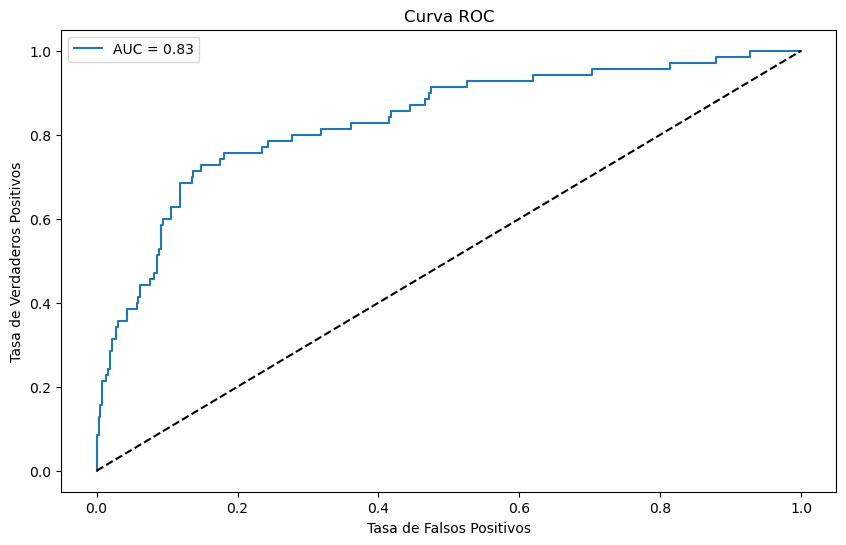

In [456]:
from sklearn.metrics import roc_curve, roc_auc_score

# Obtener las probabilidades de predicción
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Graficar la curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='best')
plt.show()

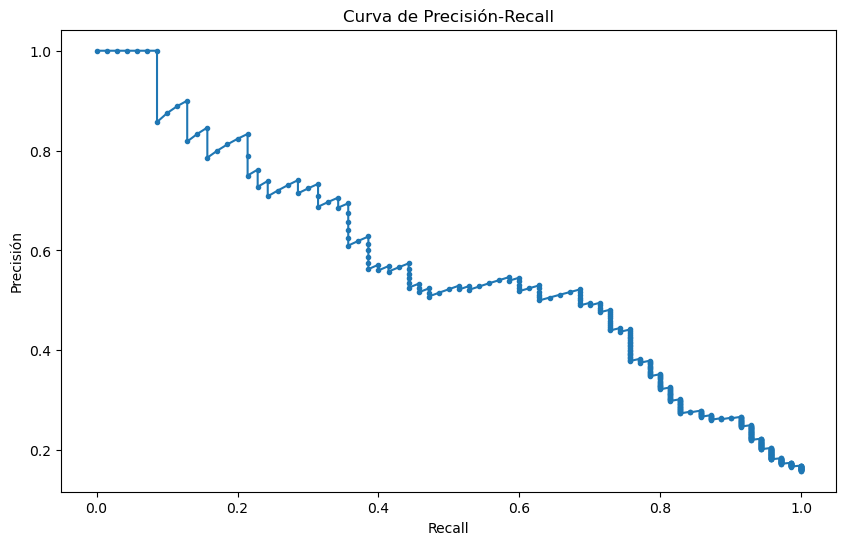

In [457]:
from sklearn.metrics import precision_recall_curve

# Calcular la curva de precisión-recall
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Graficar la curva de precisión-recall
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall')
plt.show()

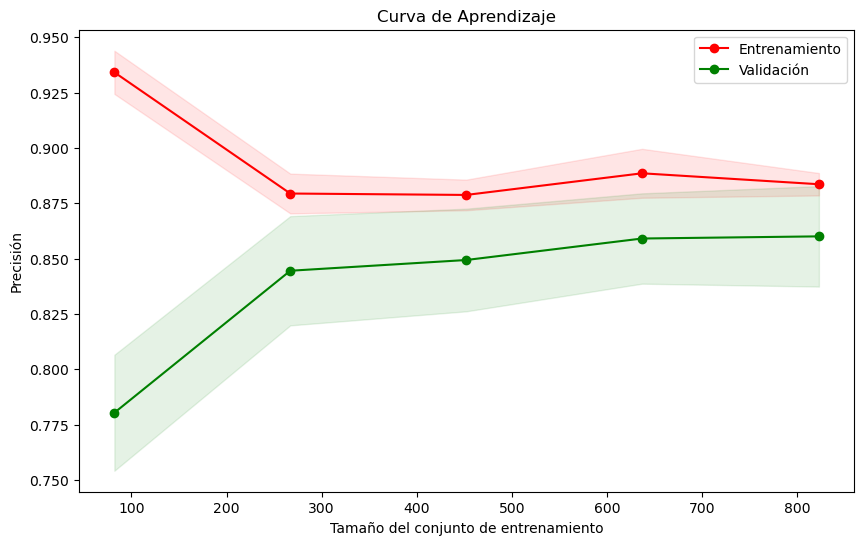

In [458]:
from sklearn.model_selection import learning_curve

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias y desviaciones estándar
train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Entrenamiento')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Validación')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='best')
plt.show()

In [14]:
from pycaret.classification import *
s = setup(df_clean, target = 'abandono', session_id = 123)

,Description,Value
0,Session id,123
1,Target,abandono
2,Target type,Binary
3,Target mapping,"No: 0, Yes: 1"
4,Original data shape,"(1470, 26)"
5,Transformed data shape,"(1470, 63)"
6,Transformed train set shape,"(1029, 63)"
7,Transformed test set shape,"(441, 63)"
8,Ordinal features,2
9,Numeric features,12


In [15]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8610,0.8067,0.8610,0.8409,0.8383,0.3418,0.3746,0.6140
ridge,Ridge Classifier,0.8581,0.0000,0.8581,0.8544,0.8155,0.2241,0.3165,0.0810
lda,Linear Discriminant Analysis,0.8581,0.7967,0.8581,0.8389,0.8378,0.3459,0.3738,0.0770
ada,Ada Boost Classifier,0.8571,0.8037,0.8571,0.8378,0.8372,0.3430,0.3706,0.1130
rf,Random Forest Classifier,0.8552,0.7649,0.8552,0.8613,0.8067,0.1844,0.2935,0.1930
gbc,Gradient Boosting Classifier,0.8533,0.7972,0.8533,0.8349,0.8264,0.2904,0.3326,0.1610
et,Extra Trees Classifier,0.8503,0.7651,0.8503,0.8133,0.8081,0.1962,0.2456,0.1810
lightgbm,Light Gradient Boosting Machine,0.8464,0.7595,0.8464,0.8223,0.8222,0.2786,0.3090,53.1180
dummy,Dummy Classifier,0.8387,0.5000,0.8387,0.7034,0.7651,0.0000,0.0000,0.1250
knn,K Neighbors Classifier,0.8105,0.5785,0.8105,0.7356,0.7653,0.0270,0.0302,0.0960


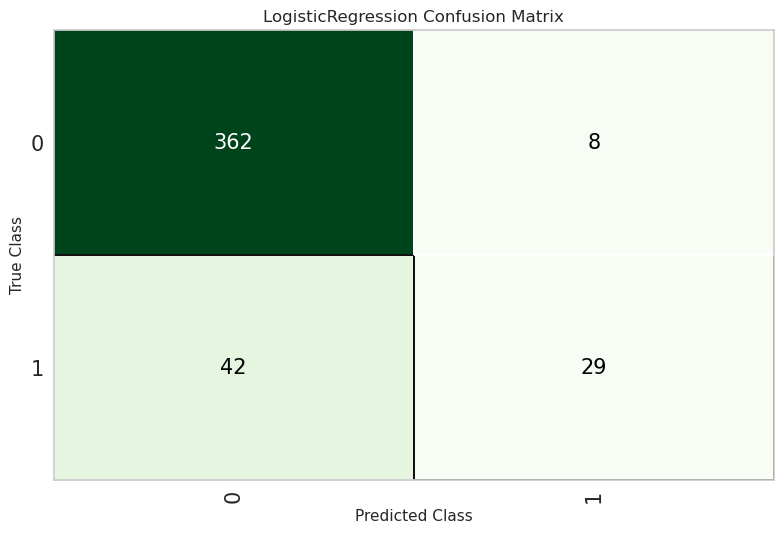

In [17]:
plot_model(best, plot = 'confusion_matrix')

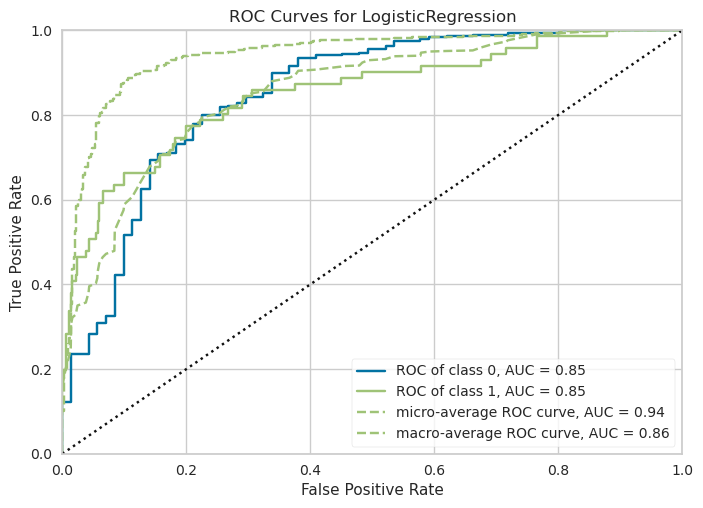

In [18]:
plot_model(best, plot = 'auc')

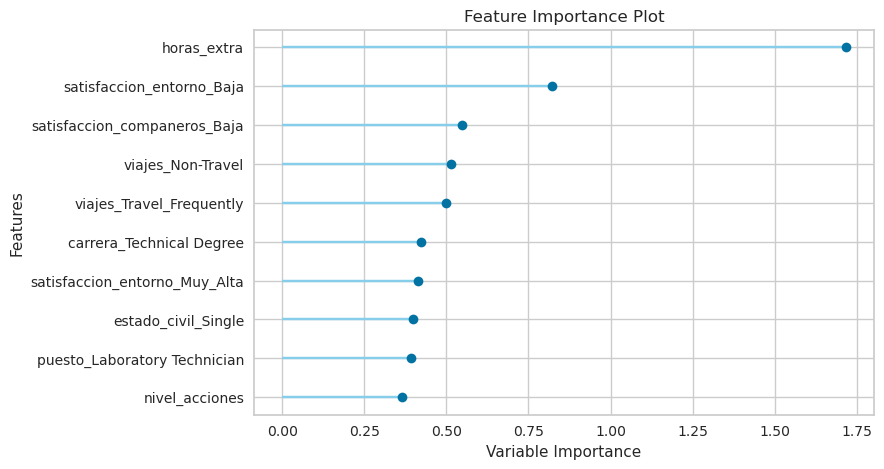

In [19]:
plot_model(best, plot = 'feature')

In [20]:
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8866,0.8516,0.8866,0.8780,0.8713,0.4796,0.5128


In [21]:
holdout_pred.head(10)

,edad,viajes,departamento,distancia_casa,educacion,carrera,satisfaccion_entorno,sexo,implicacion,nivel_laboral,...,satisfaccion_companeros,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual,abandono,prediction_label,prediction_score
id,,,,,,,,,,,,,,,,,,,,,
1257,36,Travel_Frequently,Research & Development,3,Universitaria,Technical Degree,Alta,3.0,Alta,1,...,Alta,0,12,2,11,0,7,No,No,0.9718
1356,34,Travel_Rarely,Sales,15,Universitaria,Medical,Alta,3.0,Alta,2,...,Muy_Alta,0,10,6,10,9,6,No,No,0.8496
611,29,Travel_Rarely,Research & Development,19,Universitaria,Technical Degree,Muy_Alta,3.0,Alta,2,...,Media,2,8,2,3,1,2,No,No,0.9084
100,35,Travel_Rarely,Sales,1,Secundaria,Marketing,Alta,2.0,Media,2,...,Media,0,16,2,15,2,8,No,No,0.9337
621,34,Travel_Rarely,Sales,21,Master,Life Sciences,Muy_Alta,4.0,Muy_Alta,2,...,Muy_Alta,0,10,3,10,5,7,No,No,0.9365
1509,49,Travel_Rarely,Research & Development,3,Secundaria,Medical,Alta,2.0,Media,2,...,Baja,1,10,3,3,1,2,No,No,0.9124
793,29,Travel_Rarely,Research & Development,27,Universitaria,Medical,Media,3.0,Alta,2,...,Baja,1,11,3,8,1,1,No,No,0.8536
369,25,Non-Travel,Research & Development,5,Master,Life Sciences,Media,4.0,Muy_Alta,2,...,Muy_Alta,2,6,2,6,1,5,No,No,0.9965
1267,44,Travel_Rarely,Sales,5,Universitaria,Marketing,Media,3.0,Alta,5,...,Alta,1,26,5,22,3,10,No,No,0.9973
